# Zooniverse - Advanced Aggregation with _Caesar_: Plotting penguin clusters

This notebook covers functions that can be used to plot the cluster data produced by the Zooniverse's point reducer code, following the example presented in the `Working_with_data.ipynb` notebook. The output reducer `.csv` file provides the original point data, probabilities of the points belonging in a cluster, the location of identified clusters, the covariance of the identified clusters, and the lifetimes of identified clusters.

Note:
- covariance = a measure of the strength of the correlation (joint variability) between two random variables.
- cluster lifetime = a measure of how confident the clustering algorithm is of that cluster (longer lifetime = more confident).

## Table of Contents

1. [Setup](#Setup)
2. [Define functions](#Define-functions)
    1. [Using covariance values to draw a 2-$\sigma$ ellipse](#Using-covariance-values-to-draw-a-2-$\sigma$-ellipse)
    2. [Plotting the original subject image](#Plotting-the-original-subject-image)
    3. [Plotting the data and clusters on the image](#Plotting-the-data-and-clusters-on-the-image)
3. [Reading in the data](#Reading-in-the-data)
4. [Plotting one image](#Plotting-one-image)
5. [Plotting all the images](#Plotting-all-the-images)

## Setup

First, let's import some Python packages to be used for plotting (`matplotlib`, `seaborn`), reading in images (`skimage`), reading in data tables (`pandas`), and working with arrays (`scipy` and `numpy`). As data in the `.csv` files are stored in JSON format, we'll also import the `unjson_dataframe` command from `panoptes_aggregation` to make them easier to handle.

In [1]:
from skimage import io
from panoptes_aggregation.csv_utils import unjson_dataframe
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas
import scipy.linalg as sl
import numpy as np
import seaborn as sns

## Define functions

### Using covariance values to draw a 2-$\sigma$ ellipse

The reduction code provides the covariance measurements for the identified clusters: this information can be used to create uncertainty ellipses. The eigenvalues of the covariance matrix give the semi-major and semi-minor axes of the ellipse, and the angle between the eigenvectors gives the angle of the ellipse. The `matplotlib` ellipse object is returned once these values have been calculated.

In [2]:
def cov_to_ellipse(cov, pos, nstd=1, **kwargs):
    eigvec, eigval, V = sl.svd(cov, full_matrices=False) # the eigenvalues are the variance along the eigenvectors
    theta = np.degrees(np.arctan2(eigvec[1, 0], eigvec[0, 0])) # the angle the first eigenvector makes with the x-axis
    width, height = 2 * nstd * np.sqrt(eigval) # full width and height of ellipse (not radius)
    return patches.Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

### Plotting the original subject image

This function takes in the `path` to an image and uses `matplotlib` to display it.  It is displayed using the standard image coordinate system with the origin in the upper left of the image.  This function ensures that the image is plotted with the same size and aspect ratio as the original image.

In [3]:
def display_image_in_actual_size(path):
    im_data = io.imread(path) # read in the image
    dpi = 100
    height, width, depth = im_data.shape
    
    # Determine the figure size (in inches) needed to fit the image:
    figsize = width / float(dpi), height / float(dpi)
    
    # Create a figure of the right size with one axes that takes up the full figure:
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    
    ax.axis('off') # hide spines, ticks, etc.
    ax.imshow(im_data) # display the image
    return fig, ax

### Plotting the data and clusters on the image

The final plotting function puts everything together and plots the original data points and the identified clusters on the original image.  It takes in the `path` to the original image, and the `aggregate` data for the image (assumed to be a row from a `pandas` data frame).

Each of the point marker tools are given a unique color, and the saturation of the points is proportional to the probability of the data point belonging to a cluster (i.e. the closer to grey a point is the more likely it is an outlier).

The transparency of the ellipses is proportional to the lifetime of the identified cluster (i.e. shorter lived clusters are more transparent).

The final cluster counts for each point tool are displayed in the figure's legend.

In [4]:
def plot_points(path, aggregate):
    # Create dictionary containing labels, colours, and initial 
    # counts (zero) for each point marker tool (penguin category):
    labels = {
        0: {
            'label': 'Adults',
            'color': '#d62728',
            'count': 0
        },
        1: {
            'label': 'Chicks',
            'color': '#2ca02c',
            'count': 0
        },
        2: {
            'label': 'Eggs',
            'color': '#bcbd22',
            'count': 0
        }
    }
    
    # Plot the original subject image:
    fig, ax = display_image_in_actual_size(path)
    
    # Plot points and cluster ellipses for each point marker tool:
    for tool in labels.keys():
        cluster_x = f'data.frame0.T0_tool{tool}_clusters_x'
        cluster_y = f'data.frame0.T0_tool{tool}_clusters_y'
        cluster_xx = f'data.frame0.T0_tool{tool}_clusters_var_x'
        cluster_yy = f'data.frame0.T0_tool{tool}_clusters_var_y'
        cluster_xy = f'data.frame0.T0_tool{tool}_clusters_var_x_y'
        cluster_prob = f'data.frame0.T0_tool{tool}_clusters_persistance'
        points_x = f'data.frame0.T0_tool{tool}_points_x'
        points_y = f'data.frame0.T0_tool{tool}_points_y'
        points_prob = f'data.frame0.T0_tool{tool}_cluster_probabilities'
        # Plot cluster ellipses:
        if isinstance(aggregate[cluster_x], list) and isinstance(aggregate[cluster_y], list):
            plot_props = labels[tool]
            probs = np.array(aggregate[cluster_prob])
            max_probs = probs.max()
            props = zip(
                aggregate[cluster_x],
                aggregate[cluster_y],
                aggregate[cluster_xx],
                aggregate[cluster_yy],
                aggregate[cluster_xy],
                aggregate[cluster_prob]
            )
            for x, y, xx, yy, xy, prob in props:
                cov = np.array([[xx, xy], [xy, yy]])
                pos = np.array([x, y])
                color = plot_props['color']
                alpha = 1
                if prob / max_probs <= 0.5:
                    alpha = 0.7
                if prob / max_probs <= 0.1:
                    alpha = 0.3
                # Use covariance values to draw a 2-sigma ellipse:
                ellipse = cov_to_ellipse(
                    cov,
                    pos,
                    nstd=2,
                    edgecolor=color,
                    facecolor='none',
                    lw=2,
                    alpha=alpha
                )
                ax.add_artist(ellipse)
                labels[tool]['count'] += 1
        # Plot points:
        if isinstance(aggregate[points_x], list) and isinstance(aggregate[points_y], list):
            plot_props = labels[tool]
            colors = [sns.desaturate(plot_props['color'], max(prob, 0.4)) for prob in aggregate[points_prob]]
            ax.scatter(
                aggregate[points_x],
                aggregate[points_y],
                c=colors,
                s=3,
                label='{0} ({1})'.format(plot_props['label'], plot_props['count'])
            )
    plt.legend(loc=1) # add the legend to the figure
    return fig, ax

## Reading in the data

Now that the general plotting functions are defined, we can read in the data.  These lines of code should be adjusted to point to the directories where your data is kept.

- `path_reduction`: The file path to the Zooniverse's data reduction file (the `.csv` file produced by the point reducer).
- `base_path_images`: The file path to the original Penguin Watch images (note: the `{0}.png` at the end of this path is important and should not be changed).

In [5]:
path_reduction = 'aggregation_results/point_reducer_hdbscan_example.csv'

reductions = pandas.read_csv(path_reduction) # read in the data from the .csv file
unjson_dataframe(reductions) # convert the data to a pandas DataFrame

base_path_images = 'data/penguin-watch-subjects/{0}.png'

## Plotting one image

Here is example code for plotting and displaying one image. The `iloc[0]` on the first line tells the code to "grab the first row": you can change the `0` to a different number (up to `49`) to see a different subject.

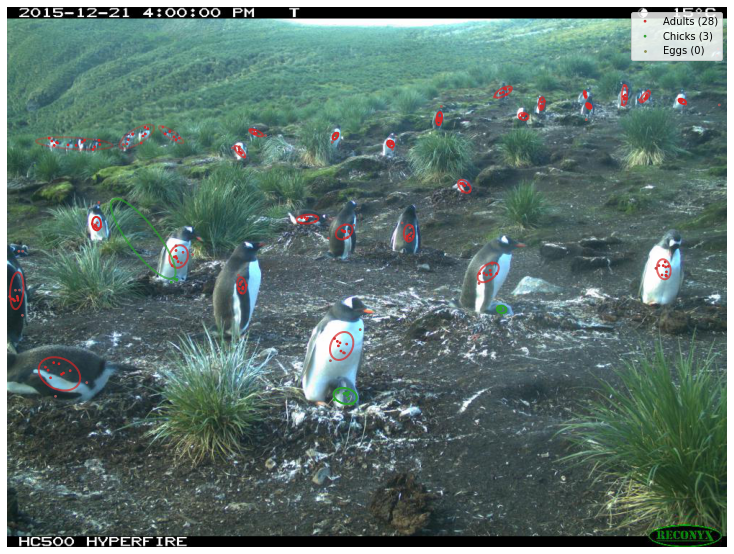

In [6]:
reduction = reductions.iloc[0]
image_path = base_path_images.format(reduction.subject_id)
fig, ax = plot_points(image_path, reduction)
plt.show()

## Plotting all the images

Make a new folder in the `aggregation_results` directory called `PW_clusters`.  This `for` loop goes through every row of the reduced data, creates the plot, and saves the images to the newly created folder.

In [ ]:
output_path = 'aggregation_results/PW_clusters/{0}_clusters.png'

for sdx, reduction in reductions.iterrows():
    output_name = output_path.format(reduction.subject_id)
    image_path = base_path_images.format(reduction.subject_id)
    fig, ax = plot_points(image_path, reduction)
    fig.savefig(output_name)
    plt.close(fig)